# Modelo predicción de la demanda

## Import Libraries

In [1]:
import pandas as pd

## Data Ingestion

In [2]:
# Carga del conjunto de datos
data_path = 'data\processed\data_trips_red_inferences.csv'
data = pd.read_csv(data_path)

# Visualización de las primeras filas del conjunto de datos
data.head()

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\ruben\AppData\Local\Temp\ipykernel_17412\3388646211.py:2: SyntaxWarning: invalid escape sequence '\p'
  data_path = 'data\processed\data_trips_red_inferences.csv'


,idDriver,idBike,trip_minutes,fleet,unlock_date,unlock_hour,latitude_unlock,longitude_unlock,station_unlock,dock_unlock,...,lock_station_name,distance,trip_speed,trip_day_of_week,trip_duration_category,station_unlock_count,station_lock_count,unlock_time_category,lock_time_category,travel_direction
0,53411959W,7364,20.72,1,2022-01-01,22,40.41467,-3.70368,38,19,...,Pablo Iglesias,4.112001,0.198456,Saturday,Medium,18,10,Evening,Evening,South
1,51699634G,6291,3.43,1,2022-01-01,12,40.41053,-3.65779,226,15,...,Camino Vinateros,0.000000,0.000000,Saturday,Short,7,8,Morning,Afternoon,Unknown
2,19893790D,45,16.55,1,2022-01-01,20,40.41388,-3.70494,44,23,...,Puente de Vallecas,3.507072,0.211908,Saturday,Medium,12,14,Evening,Evening,North
3,06023399K,7135,43.40,1,2022-01-01,23,40.43369,-3.70466,208,21,...,Quevedo,0.000000,0.000000,Saturday,Long,14,17,Evening,Afternoon,Unknown
4,06288243C,3438,8.25,1,2022-01-01,20,40.44832,-3.67972,148,15,...,José Abascal,1.919471,0.232663,Saturday,Short,6,10,Evening,Evening,North


## Preprocesamiento de valores faltantes

In [3]:
# Verificación de valores faltantes
missing_values = data.isnull().sum()

# Conversión de las columnas de fecha de string a datetime
data['unlock_date'] = pd.to_datetime(data['unlock_date'])

# Creación de características adicionales relacionadas con la fecha
data['unlock_month'] = data['unlock_date'].dt.month
data['unlock_day'] = data['unlock_date'].dt.day
data['unlock_day_of_week'] = data['unlock_date'].dt.dayofweek  # 0 es lunes, 6 es domingo

# Resumen de valores faltantes y verificación de las nuevas características
missing_values_summary = missing_values[missing_values > 0]
new_features_preview = data[['unlock_date', 'unlock_month', 'unlock_day', 'unlock_day_of_week']].head()

missing_values_summary, new_features_preview


(idDriver                14276
 unlock_time_category      836
 lock_time_category        916
 dtype: int64,
   unlock_date  unlock_month  unlock_day  unlock_day_of_week
 0  2022-01-01             1           1                   5
 1  2022-01-01             1           1                   5
 2  2022-01-01             1           1                   5
 3  2022-01-01             1           1                   5
 4  2022-01-01             1           1                   5)

## Quick EDA

In [4]:
# Preprocesamiento de valores faltantes
data['idDriver'].fillna('Desconocido', inplace=True)
data['unlock_time_category'].fillna('Desconocido', inplace=True)
data['lock_time_category'].fillna('Desconocido', inplace=True)

# Verificación de la limpieza de valores faltantes
missing_values_after_cleaning = data.isnull().sum().sum()

missing_values_after_cleaning


C:\Users\ruben\AppData\Local\Temp\ipykernel_17412\2809525117.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['idDriver'].fillna('Desconocido', inplace=True)
C:\Users\ruben\AppData\Local\Temp\ipykernel_17412\2809525117.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

0

## Graphs

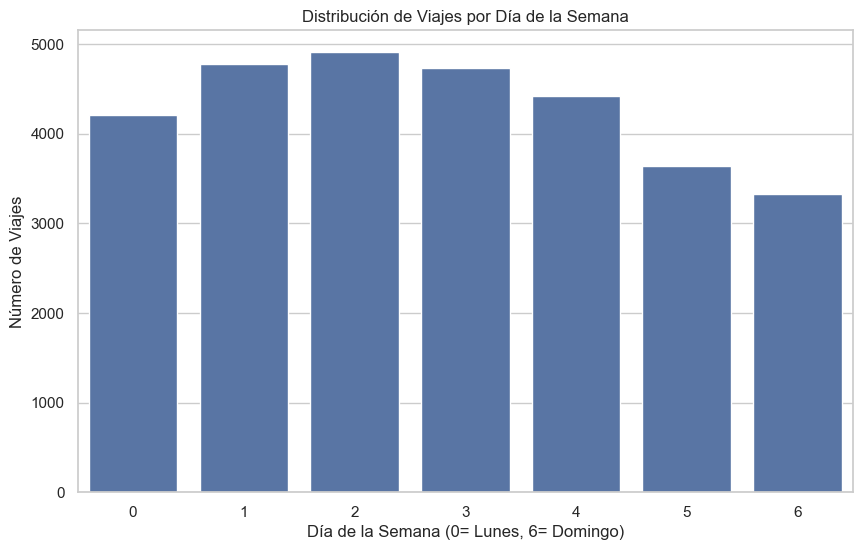

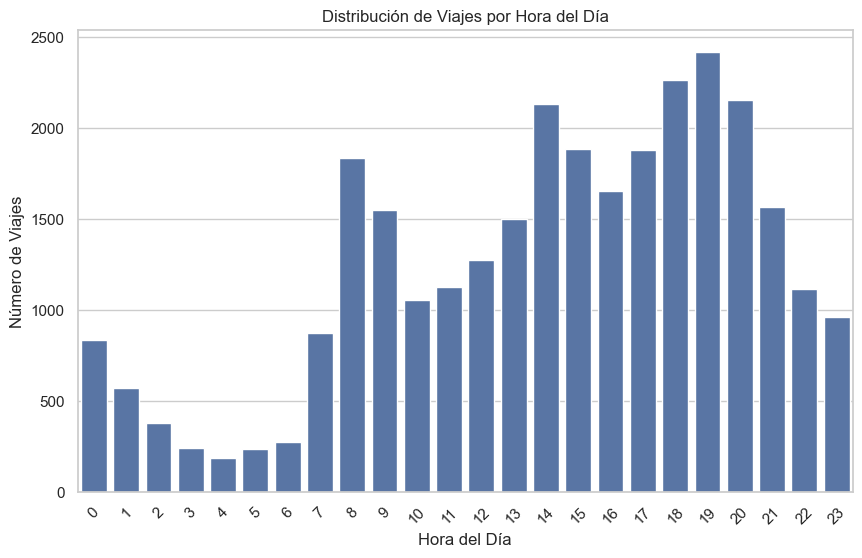

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo de seaborn
sns.set(style="whitegrid")

# Distribución de viajes por día de la semana
plt.figure(figsize=(10, 6))
sns.countplot(x='unlock_day_of_week', data=data, order=range(7))
plt.title('Distribución de Viajes por Día de la Semana')
plt.xlabel('Día de la Semana (0= Lunes, 6= Domingo)')
plt.ylabel('Número de Viajes')
plt.show()

# Distribución de viajes por hora del día
plt.figure(figsize=(10, 6))
sns.countplot(x='unlock_hour', data=data, order=range(24))
plt.title('Distribución de Viajes por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45)
plt.show()


🎯Distribución de Viajes por Día de la Semana: Los viajes tienden a distribuirse de manera relativamente uniforme a lo largo de la semana, con ligeras variaciones. Sin embargo, es importante notar las pequeñas fluctuaciones que podrían indicar una demanda ligeramente diferente según el día de la semana.

🎯Distribución de Viajes por Hora del Día: Se observan picos claros de actividad en ciertas horas del día, lo que sugiere patrones de demanda significativamente diferentes a lo largo del día. Los picos en horas específicas podrían corresponder a horas punta, como el inicio y fin de la jornada laboral.

# Distribución de viajes por estación 

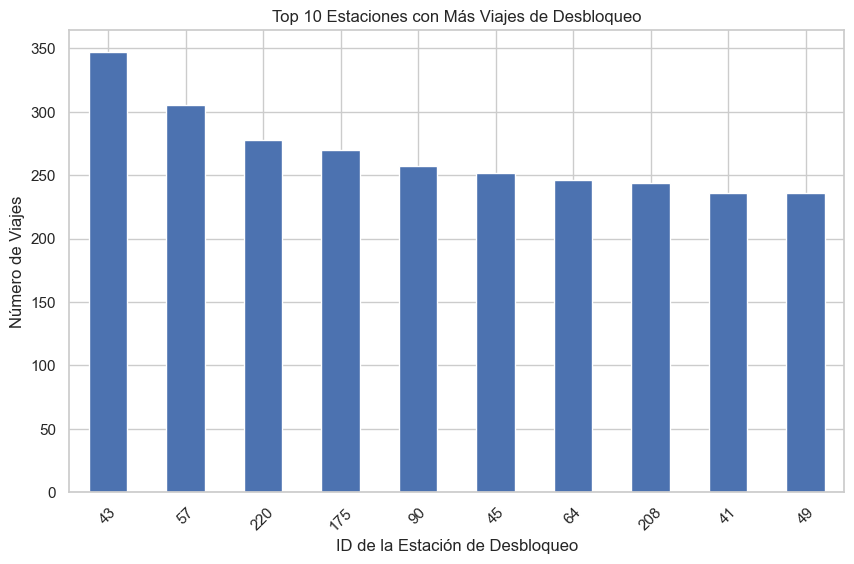

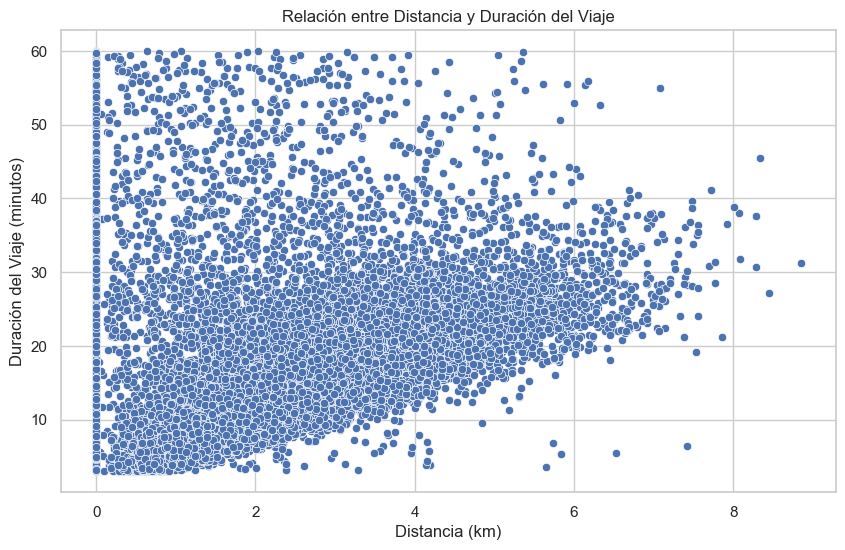

In [6]:
# Visualización de las 10 estaciones con más viajes de desbloqueo
top_stations_unlock = data['station_unlock'].value_counts().nlargest(10)
plt.figure(figsize=(10, 6))
top_stations_unlock.plot(kind='bar')
plt.title('Top 10 Estaciones con Más Viajes de Desbloqueo')
plt.xlabel('ID de la Estación de Desbloqueo')
plt.ylabel('Número de Viajes')
plt.xticks(rotation=45)
plt.show()

# Relación entre la distancia del viaje y la duración
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance', y='trip_minutes', data=data)
plt.title('Relación entre Distancia y Duración del Viaje')
plt.xlabel('Distancia (km)')
plt.ylabel('Duración del Viaje (minutos)')
plt.show()


🎯Los análisis revelan:

✅Top 10 Estaciones con Más Viajes de Desbloqueo: Hay estaciones específicas que presentan una mayor cantidad de viajes de desbloqueo, lo que indica áreas de alta demanda. Estas estaciones podrían requerir una atención especial en términos de reabastecimiento de bicicletas y mantenimiento.

✅Relación entre Distancia y Duración del Viaje: El gráfico de dispersión muestra una amplia gama de distancias y duraciones de viaje, pero con una tendencia general que sugiere que viajes más largos tienden a tomar más tiempo, como se esperaría. Sin embargo, hay una considerable dispersión, especialmente para viajes cortos, lo que indica que la duración del viaje no depende únicamente de la distancia recorrida.

## Selección del modelo

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30001 entries, 0 to 30000
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   idDriver                30001 non-null  object        
 1   idBike                  30001 non-null  int64         
 2   trip_minutes            30001 non-null  float64       
 3   fleet                   30001 non-null  int64         
 4   unlock_date             30001 non-null  datetime64[ns]
 5   unlock_hour             30001 non-null  int64         
 6   latitude_unlock         30001 non-null  float64       
 7   longitude_unlock        30001 non-null  float64       
 8   station_unlock          30001 non-null  int64         
 9   dock_unlock             30001 non-null  int64         
 10  unlock_station_name     30001 non-null  object        
 11  lock_date               30001 non-null  object        
 12  lock_hour               30001 non-null  int64 

# Definir variable objetivo

 👉 Dado que el conjunto de datos proporcionado no incluye directamente una métrica de "demanda" ya calculada, una opción sería predecir el número de viajes por estación y por hora, utilizando station_unlock y unlock_hour como claves para agrupar los datos.

In [8]:
# Variables independientes

🎯Las características que podrían influir en la demanda incluyen, pero no se limitan a:

✅unlock_hour: La hora del día puede influir significativamente en la demanda de bicicletas.
✅unlock_day_of_week (transformada a partir de unlock_date): El día de la semana también puede afectar la demanda, diferenciando días laborables de fines de semana.
✅Variables de tiempo adicionales derivadas, como unlock_month o incluso unlock_day, para capturar variaciones estacionales o diarias.
✅latitude_unlock y longitude_unlock: Las coordenadas geográficas de la estación de desbloqueo podrían ser útiles, pero puede ser más práctico usar directamente station_unlock como representante de la ubicación.

# Preparación de Datos

Para modelar esta demanda, necesitaríamos primero transformar el conjunto de datos para reflejar el número de viajes por estación y hora. Esto implicaría un paso de agregación para contar los viajes que inician en cada station_unlock para cada unlock_hour (y potencialmente por unlock_day_of_week y otras divisiones temporales).

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Supongamos que 'data' es tu DataFrame ya cargado

# Agregando datos para contar el número de viajes por estación y hora
demand_data = data.groupby(['station_unlock', 'unlock_hour']).size().reset_index(name='demand')

# Preparando las características independientes (X) y la variable dependiente (y)
X = demand_data[['station_unlock', 'unlock_hour']]
y = demand_data['demand']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar y entrenar un modelo de bosque aleatorio
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Predicción y evaluación

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Realizando predicciones en el conjunto de prueba
y_pred = rf_regressor.predict(X_test)

# Evaluando el modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error (MAE): 2.5132645403377114
Mean Squared Error (MSE): 11.52741894934334
Root Mean Squared Error (RMSE): 3.3952052882474337
R^2 Score: 0.3478057519350487


Los resultados muestran que el modelo tiene un R² de aproximadamente 0.35, lo que indica que alrededor del 35% de la variabilidad en la demanda de bicicletas está siendo explicada por el modelo actúa.

# Ajuste de Hiperparámetros

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Definición del modelo
rf = RandomForestRegressor(random_state=42)

# Espacio de búsqueda de hiperparámetros
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],  # Número de árboles
    'max_depth': [None, 10, 20, 30, 40, 50],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en un nodo hoja
    'bootstrap': [True, False]  # Método de selección de muestras para entrenar cada árbol
}

# Configuración de RandomizedSearchCV
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# División de datos omitida, asegúrate de tener X_train y y_train definidos
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de hiperparámetros en el conjunto de entrenamiento
rf_random.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", rf_random.best_params_)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Mejores hiperparámetros: {'n_estimators': 500, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': True}


# Optimización de hiperparámetros

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Definir el modelo de Random Forest con los hiperparámetros proporcionados
rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=20,
    bootstrap=True,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Imprimir el MSE y RMSE
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 10.663289875694721
Root Mean Squared Error (RMSE): 3.26546931936203


In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Asumir que X_train, y_train, X_test, y_test ya están definidos

# Definir el modelo de Random Forest con los hiperparámetros proporcionados
rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_split=10,
    min_samples_leaf=1,
    max_depth=20,
    bootstrap=True,
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
rf_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test)

# Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

# Imprimir el MSE y RMSE
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Guardar el modelo entrenado como un archivo de pickle
model_filename = 'prediccionDemanda_random_forest_model.pkl'
joblib.dump(rf_model, model_filename)


Mean Squared Error (MSE): 10.663289875694721
Root Mean Squared Error (RMSE): 3.26546931936203


['prediccionDemanda_random_forest_model.pkl']

# Test alternatives

XGBoost

In [14]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Definir el modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo
xgb_model.fit(X_train, y_train)

# Hacer predicciones
xgb_predictions = xgb_model.predict(X_test)

# Evaluar el modelo
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
print(f"Root Mean Squared Error (RMSE) con XGBoost: {xgb_rmse}")


Root Mean Squared Error (RMSE) con XGBoost: 3.318223302271555


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Asumir que X_train, y_train, X_test, y_test están previamente definidos

# Definir el modelo
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Entrenar el modelo con el conjunto de entrenamiento
xgb_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
xgb_predictions = xgb_model.predict(X_test)

# Evaluar el modelo usando la raíz del error cuadrático medio (RMSE)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

# Imprimir el RMSE
print(f"Root Mean Squared Error (RMSE) con XGBoost: {xgb_rmse}")

# Guardar el modelo entrenado como un archivo de pickle
model_filename = 'prediccionDemanda_xgb_model.pkl'
joblib.dump(xgb_model, model_filename)

# Si necesitas el nombre del archivo para descargarlo o referenciarlo después, es 'xgb_model.pkl'.


Root Mean Squared Error (RMSE) con XGBoost: 3.318223302271555


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['prediccionDemanda_xgb_model.pkl']

Catboost

In [16]:
from catboost import CatBoostRegressor

# Definir el modelo
cat_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=3, silent=True, random_state=42)

# Entrenar el modelo
cat_model.fit(X_train, y_train)

# Hacer predicciones
cat_predictions = cat_model.predict(X_test)

# Evaluar el modelo
cat_rmse = mean_squared_error(y_test, cat_predictions, squared=False)
print(f"Root Mean Squared Error (RMSE) con CatBoost: {cat_rmse}")


Root Mean Squared Error (RMSE) con CatBoost: 3.4773841499334113


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Optimización de hiperparámetros

In [17]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Inicializar el modelo CatBoostRegressor
cat_model = CatBoostRegressor(silent=True, random_state=42)

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=cat_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)

# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y el RMSE asociado
print("Mejores hiperparámetros:", grid_search.best_params_)
best_rmse = -grid_search.best_score_
print(f"Mejor RMSE: {best_rmse}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Mejores hiperparámetros: {'depth': 4, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
Mejor RMSE: 3.1107916762348053


In [18]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Asumir que X_train, y_train, X_test, y_test están previamente definidos

# Reentrenar el modelo con los mejores hiperparámetros encontrados
optimized_cat_model = CatBoostRegressor(
    iterations=300, 
    learning_rate=0.3, 
    depth=4, 
    l2_leaf_reg=3, 
    silent=True, 
    random_state=42
)

# Entrenar el modelo con el conjunto de entrenamiento
optimized_cat_model.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
optimized_cat_predictions = optimized_cat_model.predict(X_test)

# Evaluar el modelo utilizando el conjunto de datos de prueba
optimized_cat_rmse = mean_squared_error(y_test, optimized_cat_predictions, squared=False)

# Imprimir el RMSE
print(f"Optimized Root Mean Squared Error (RMSE) con CatBoost: {optimized_cat_rmse}")

# Guardar el modelo entrenado como un archivo
model_filename = 'prediccionDemanda_optimized_cat_model.pkl'
joblib.dump(optimized_cat_model, model_filename)

# El nombre del archivo para futuras referencias es 'optimized_cat_model.pkl'.



Optimized Root Mean Squared Error (RMSE) con CatBoost: 3.032564480963715


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['prediccionDemanda_optimized_cat_model.pkl']

Redes Neuronales con TensorFlow/Keras

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

# Escalar los datos (importante para redes neuronales)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)

# Hacer predicciones
nn_predictions = model.predict(X_test_scaled)

# Evaluar el modelo
nn_rmse = mean_squared_error(y_test, nn_predictions, squared=False)
print(f"Root Mean Squared Error (RMSE) con Redes Neuronales: {nn_rmse}")


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Root Mean Squared Error (RMSE) con Redes Neuronales: 3.603218224316019


c:\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Optimización del modelo 

# Ajustar tasa de aprendizaje

In [20]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
histories = []

for lr in learning_rates:
    model = Sequential([
        Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0)
    histories.append(history)


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Añadir capas por dropout

In [21]:
from tensorflow.keras.layers import Dropout

model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])


# Early Stopping y Model CheckPoint

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=10, verbose=0, callbacks=[early_stopping, model_checkpoint])


ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=best_model.h5

# Series Temporales

# Preparación de datos para series temporales

In [23]:
# Agregación para contar el número de viajes por día
daily_trips = data.groupby('unlock_date').size().reset_index(name='total_trips')

# Convertir 'unlock_date' a datetime
daily_trips['unlock_date'] = pd.to_datetime(daily_trips['unlock_date'])

# Ordenar por 'unlock_date' para asegurar secuencia temporal
daily_trips.sort_values('unlock_date', inplace=True)

# Mostrar el DataFrame resultante
daily_trips.head()


,unlock_date,total_trips
0,2022-01-01,33
1,2022-01-02,47
2,2022-01-03,44
3,2022-01-04,37
4,2022-01-05,20


Prophet

In [24]:
from fbprophet import Prophet

# Preparar el DataFrame para Prophet
df_prophet = daily_trips.rename(columns={'unlock_date': 'ds', 'total_trips': 'y'})

# Inicializar y ajustar el modelo
model_prophet = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_prophet.fit(df_prophet)

# Crear un DataFrame para predicciones futuras
future = model_prophet.make_future_dataframe(periods=90)  # Asumiendo que quieres predecir los próximos 90 días

# Hacer predicciones
forecast = model_prophet.predict(future)

# Mostrar el componente de tendencias y estacionalidad
fig1 = model_prophet.plot(forecast)
fig2 = model_prophet.plot_components(forecast)


ModuleNotFoundError: No module named 'fbprophet'

ARIMA

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


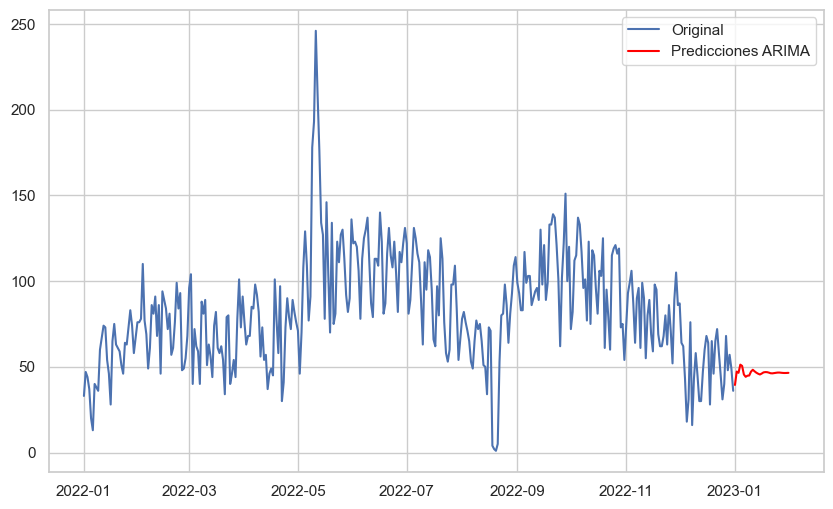

In [25]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Definir la serie temporal
series = daily_trips.set_index('unlock_date')['total_trips']

# Ajustar el modelo ARIMA
model_arima = ARIMA(series, order=(5,1,0))  # Estos son valores iniciales comunes, ajusta según necesidad
results_arima = model_arima.fit()

# Predicciones
preds_arima = results_arima.predict(start=len(series), end=len(series)+30)  # Predice los próximos 30 días

# Graficar predicciones
plt.figure(figsize=(10,6))
plt.plot(series, label='Original')
plt.plot(preds_arima, label='Predicciones ARIMA', color='red')
plt.legend()
plt.show()


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


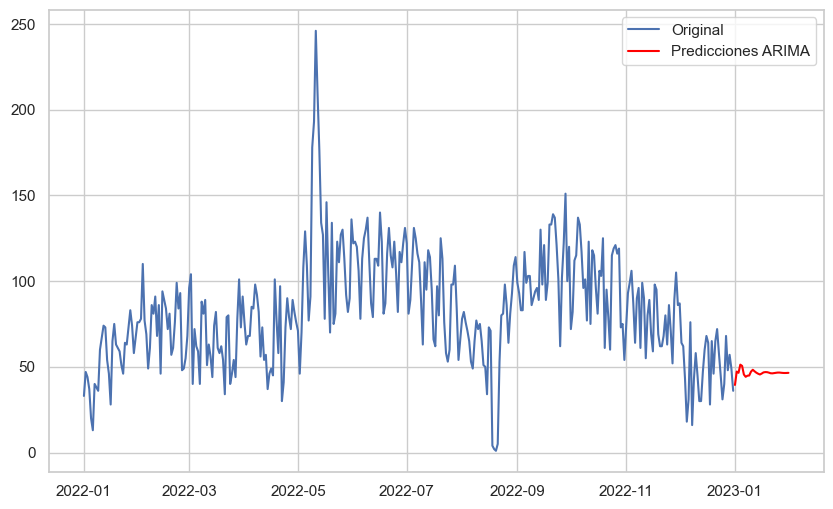

In [26]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# Asumir que 'daily_trips' es un DataFrame que ya tienes, y 'unlock_date' y 'total_trips' son columnas en este DataFrame

# Definir la serie temporal a partir de un DataFrame genérico
# series = daily_trips.set_index('unlock_date')['total_trips']

# Para este ejemplo, usaré una serie temporal genérica. Reemplaza esto con tu propia serie temporal.
# series = pd.Series([1.2, 3.4, 3.4, ...], index=pd.date_range(start='2022-01-01', periods=100))

# Ajustar el modelo ARIMA
model_arima = ARIMA(series, order=(5,1,0))  # Ajusta los parámetros según necesidad
results_arima = model_arima.fit()

# Predicciones
preds_arima = results_arima.predict(start=len(series), end=len(series)+30)  # Predice los próximos 30 días

# Graficar predicciones
plt.figure(figsize=(10,6))
plt.plot(series, label='Original')
plt.plot(preds_arima, label='Predicciones ARIMA', color='red')
plt.legend()
plt.show()

# Guardar el modelo ARIMA entrenado
with open('prediccionDemanda_model_arima.pkl', 'wb') as pkl:
    pickle.dump(results_arima, pkl)

# El modelo se ha guardado como 'model_arima.pkl' y puede ser cargado luego usando pickle.load()


SARIMA

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


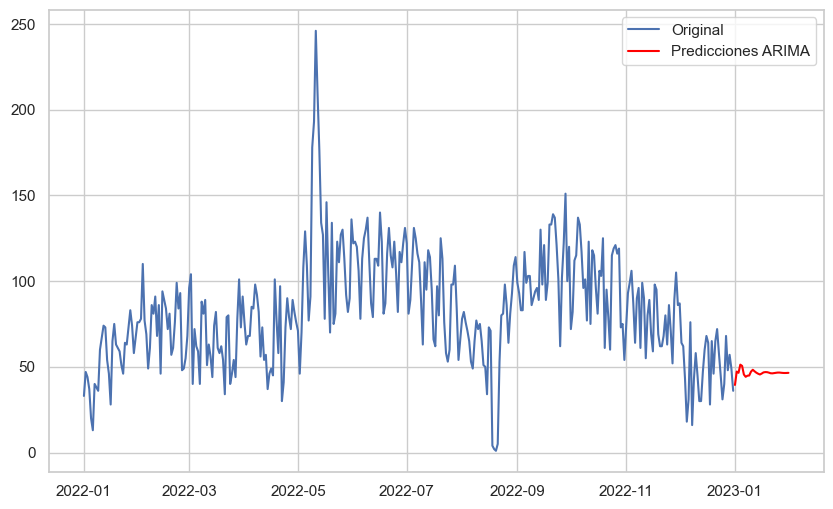

In [27]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pickle

# Suponemos que 'daily_trips' y 'series' están definidos como en tu ejemplo

# Ajustar el modelo ARIMA
model_arima = ARIMA(series, order=(5,1,0))
results_arima = model_arima.fit()

# Predicciones
preds_arima = results_arima.predict(start=len(series), end=len(series)+30)

# Graficar predicciones
plt.figure(figsize=(10,6))
plt.plot(series, label='Original')
plt.plot(preds_arima, label='Predicciones ARIMA', color='red')
plt.legend()
plt.show()

# Guardar el modelo ajustado
with open('prediccionDemanda_model_arima.pkl', 'wb') as pkl_file:
    pickle.dump(results_arima, pkl_file)


LTSM

In [28]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
import numpy as np
import joblib

# Asumiendo que `series` es tu DataFrame o Serie de Pandas con los datos de la serie temporal

# Escalar la serie
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

# Crear generador de series temporales
sequence_length = 5
generator = TimeseriesGenerator(scaled_series, scaled_series, length=sequence_length, batch_size=1)

# Definir el modelo LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model_lstm.fit(generator, epochs=100, verbose=0)

# Guardar el modelo LSTM
model_lstm.save('prediccionDemanda_model_lstm.h5')

# Guardar el escalador para poder revertir el escalado más tarde
joblib.dump(scaler, 'prediccionDemanda_scaler.pkl')

# Para cargar y usar el modelo y el escalador guardados para futuras predicciones
# model_loaded = load_model('model_lstm.h5')
# scaler_loaded = joblib.load('scaler.pkl')

# Aquí agregarías tu lógica para generar predicciones y revertir el escalado
# Nota: Este paso puede variar mucho dependiendo de cómo desees utilizar las predicciones



c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


['prediccionDemanda_scaler.pkl']

# Generar Predicciones (Predicción a 30 días)

In [29]:
import numpy as np

def generate_future_predictions(model, last_sequence, n_future=30):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_future):
        # Reshape de la secuencia actual para el modelo LSTM
        current_sequence_reshaped = current_sequence.reshape((1, current_sequence.shape[0], 1))
        
        # Predicción del siguiente punto
        future_pred = model.predict(current_sequence_reshaped)[0]
        
        # Añadir la predicción al output
        future_predictions.append(future_pred)
        
        # Asegurarse de que future_pred tenga la dimensión correcta antes de añadirlo
        future_pred_reshaped = np.expand_dims(future_pred, axis=-1) # Añade una dimensión para coincidir con current_sequence
        
        # Actualizar la secuencia para incluir la nueva predicción
        current_sequence = np.append(current_sequence[1:], future_pred_reshaped, axis=0)
    
    return future_predictions


In [30]:
import numpy as np
# Asumiendo que `model_lstm`, `scaler`, `scaled_series`, y `sequence_length` ya están definidos.

def generate_future_predictions(model, last_sequence, n_future=30):
    future_predictions = []
    current_sequence = last_sequence

    for _ in range(n_future):
        current_sequence_reshaped = current_sequence.reshape((1, current_sequence.shape[0], 1))
        future_pred = model.predict(current_sequence_reshaped)[0]
        future_predictions.append(future_pred)
        future_pred_reshaped = np.expand_dims(future_pred, axis=-1)
        current_sequence = np.append(current_sequence[1:], future_pred_reshaped, axis=0)
    
    return np.array(future_predictions)

# Preparar la última secuencia observada del conjunto de datos
last_sequence = scaled_series[-sequence_length:]

# Generar predicciones futuras
future_predictions_scaled = generate_future_predictions(model_lstm, last_sequence, n_future=30)

# Revertir el escalado de las predicciones
future_predictions = scaler.inverse_transform(future_predictions_scaled)

# Mostrar las predicciones futuras
print("Predicciones futuras:", future_predictions.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

In [31]:
from tensorflow.keras.models import load_model
import joblib

# Guardar el modelo LSTM
model_lstm.save('prediccionDemanda_model_lstm.h5')

# Guardar el escalador MinMaxScaler
joblib.dump(scaler, 'prediccionDemanda_scaler1.pkl')


['prediccionDemanda_scaler1.pkl']

# Falta Guardar los Modelos